In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import mplfinance as mpf
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import datetime

import random

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

from setup import get_task_data
import yfinance as yf

d:\conda\envs\imta\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
financial_data = {}
metadata = {}

# Stocks have different IPO date (first trade) so only last ~3 years of data used
HISTORY_SIZE = 129
TARGET_STOCKS_COUNT = 5000

stocks_df = pd.read_csv(get_task_data("StocksList.csv"))

stocks_list = stocks_df['Symbol'].astype(str).to_list()
stocks_list = list(map(lambda s: s.replace('^', '-'), stocks_list))
random.shuffle(stocks_list)

stocks_list = stocks_list[:TARGET_STOCKS_COUNT]

tickers = stocks_list
tickers_df = yf.download(tickers, period='1y')

[****                   8%%                      ]  378 of 5000 completed

Failed to get ticker 'WSO/B' reason: Expecting value: line 1 column 1 (char 0)


[******                13%%                      ]  658 of 5000 completed

Failed to get ticker 'CRD/A' reason: Expecting value: line 1 column 1 (char 0)


[*********             18%%                      ]  917 of 5000 completed

Failed to get ticker 'AKO/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************52%%                      ]  2594 of 5000 completed

Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************80%%************          ]  3998 of 5000 completed

Failed to get ticker 'CRD/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************98%%********************* ]  4905 of 5000 completed

Failed to get ticker 'BF/A' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  5000 of 5000 completed


325 Failed downloads:
['CIM-D', 'FHN-E', 'JPM-M', 'GLOP-C', 'ETI-', 'USB-A', 'GDL-C', 'NS-C', 'NSA-A', 'MFA-C', 'GNL-D', 'SCE-L', 'PEB-E', 'GNL-E', 'ET-C', 'ASB-F', 'GDV-K', 'WRB-F', 'BHR-D', 'CODI-C', 'BW-A', 'SITC-A', 'PSA-J', 'LNC-D', 'GLP-A', 'SF-C', 'GS-K', 'KREF-A', 'ECF-A', 'ET-E', 'GDV-H', 'PEB-H', 'AAIC-B', 'PMT-A', 'CEQP-', 'WFC-Z', 'CUBI-F', 'BAC-M', 'DLR-J', 'NMK-C', 'RLJ-A', 'WRB-G', 'NGL-B', 'KEY-K', 'FBRT-E', 'GSL-B', 'MS-O', 'GLU-A', 'KIM-M', 'BAC-N', 'BIP-B', 'YCBD-A', 'AAIC-C', 'RITM-B', 'PRIF-D', 'BEP-A', 'MS-K', 'FHN-C', 'NEE-R', 'USB-R', 'GAB-G', 'LFT-A', 'WFC-A', 'NREF-A', 'ICR-A', 'EQH-C', 'PCG-D', 'CLVT-A', 'OAK-B', 'JPM-L', 'EPR-G', 'GL-D', 'SHO-I', 'GS-A', 'CIM-B', 'ACR-D', 'AIG-A', 'RITM-C', 'CMRE-E', 'GNL-A', 'SPG-J', 'ALTG-A', 'BAC-E', 'NLY-I', 'AXS-E', 'ALL-B', 'ALL-I', 'NLY-F', 'NCV-A', 'SPNT-B', 'FRT-C', 'AMH-G', 'WFC-Y', 'DRH-A', 'CADE-A', 'WFC-L', 'AEL-B', 'NLY-G', 'WBS-F', 'HT-E', 'MTB-H', 'SF-B', 'OPP-B', 'CORR-A', 'CDR-B', 'VOYA-B', 'AEL-A', 'HT-C'

In [3]:
tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 2022-10-19 00:00:00 to 2023-10-18 00:00:00
Columns: 30000 entries, ('Adj Close', 'A') to ('Volume', 'ZYME')
dtypes: float64(29999), int64(1)
memory usage: 57.5+ MB


In [4]:
tickers_df = tickers_df.iloc[-HISTORY_SIZE:]

In [5]:
stocks_list[0]

'MCACW'

In [6]:
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

def extract_history(tickers_df, stock):
    multiindex = pd.MultiIndex.from_product([columns, [stock]])
    stock_df = tickers_df[multiindex]

    stock_df.columns = stock_df.columns.to_flat_index()
    stock_df = stock_df.set_axis(columns, axis=1)
    stock_df = stock_df.dropna()
    return stock_df

Our financial data is supplied with metadata: name of a stock and financial sector it belongs too

Sectors:
* Technology - category of stocks relating to the research, development, or distribution of technologically based goods and services
* Basic Materials - category made up of businesses engaged in the discovery, development, and processing of raw materials 
* Communication Services - category made up of services such as social media companies, Internet search firms, video game makers, telecom providers, and streaming media make up most of this sector
* Consumer Cyclical - category of stocks that rely heavily on the business cycle and economic conditions. Consumer cyclicals include industries such as automotive, housing, entertainment, and retail
* Consumer Defensive - category of companies that manufacture food, beverages, household and personal products, packaging, or tobacco. Also includes companies that provide services such as education and training services
* Energy - category of companies that play a role in extracting, refining, or producing sources of energy
* Financial Services - category of firms and institutions that provide financial services to commercial and retail customers
* Healthcare - category of businesses that provide medical services, manufacture medical equipment or drugs, provide medical insurance, or otherwise facilitate the provision of healthcare to patients
* Industrials - category of businesses that aid other businesses in manufacturing, shipping or producing their products
* Real Estate - category of the following: Industrial, Office, Mixed-Industrial/Office, Retail-Shopping Centers, Retail-Regional Malls, Retail-Free Standing, Residential-Apartments, Residential-Manufactured Homes, Diversified, Lodging/Resorts, Health Care, Self Storage, Specialty, Home Financing and Commercial Financing
* Utilities - category of companies that provide their customers with electricity, water, and other public utilities

In [7]:
# metadata extraction is costly and not required for classification/regression

for stock in stocks_list:    
    history = extract_history(tickers_df, stock)
    
    if len(history) < HISTORY_SIZE:
        print(f"Too short history: {len(history)}")
        continue
    
    # ticker = yf.Ticker(stock)
    # sector = ticker.info.get('sector', None)

    # if not sector:
    #    print(f"No sector specified")
    #    continue

    financial_data[stock] = history
    # metadata[stock] = sector

Too short history: 1
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 103
Too short history: 0
Too short history: 0
Too short history: 26
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 43
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 0
Too short history: 16
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 0
Too short history: 126
Too short history: 0
Too short history: 1
Too short history: 126
Too short history: 6
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 1
Too short history: 47
Too short history: 1
Too short history: 1
Too short history: 0
Too

In [8]:
len(financial_data)

4264

1. Classification

Model that predicts if the next close value will be higher than current

RNN classification

In [111]:
def log_modified(n):
    if n == 0:
        return 0
    elif n < 0:
        return -np.log(-n)
    else:
        return np.log(n)

In [148]:
classification_stocks = []
classification_history = []
classification_target = []

for stock, data in financial_data.items():
    classification_stocks.append(stock)

    close_vals = data['Close'].to_numpy()
    close_vals_delta = np.diff(close_vals)
    close_vals_delta = np.insert(close_vals_delta, 0, 0)
    close_vals_delta_normalized = np.fromiter(map(lambda n: log_modified(n), close_vals_delta), dtype=np.float32)

    classification_history.append(close_vals_delta_normalized[0:HISTORY_SIZE - 1])
    classification_target.append(int(close_vals_delta_normalized[-1] > 0))

classification_data = {
    'Stock': classification_stocks,
    'History': classification_history,
    'Target': classification_target
}

In [149]:
classification_df = pd.DataFrame.from_dict(classification_data)

In [150]:
classification_df.sample(1)

,Stock,History,Target
3893,PNF,"[0.0, 2.5257297, 2.9957285, 4.6051474, 2.65926...",1


Values of close prices represented as a sequence and sector as one-hot vector

In [296]:
classification_train_df, classification_test_df = train_test_split(classification_df, test_size=0.2)

In [297]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [298]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True, input_shape=(None, (HISTORY_SIZE - 1))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [299]:
classification_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-6),
              metrics=[
                  'accuracy', 
                  # tfa.metrics.F1Score(average='macro', num_classes=1)
                ])

In [300]:
train_size = len(classification_train_df)
test_size = len(classification_test_df)

x_train = np.array(classification_train_df['History'].tolist()).reshape(train_size, 1, HISTORY_SIZE - 1)
y_train = np.array(classification_train_df['Target'].tolist()).reshape(train_size, 1)

x_test = np.array(classification_test_df['History'].tolist()).reshape(test_size, 1, HISTORY_SIZE - 1)
y_test = np.array(classification_test_df['Target'].tolist()).reshape(test_size, 1)

In [301]:
classification_history = classification_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=500)

Epoch 1/500
107/107 [==============================] - 15s 31ms/step - loss: 4.6723 - accuracy: 0.4052 - val_loss: 4.0706 - val_accuracy: 0.3974
Epoch 2/500
107/107 [==============================] - 2s 15ms/step - loss: 3.9545 - accuracy: 0.4052 - val_loss: 3.8855 - val_accuracy: 0.3974
Epoch 3/500
107/107 [==============================] - 1s 13ms/step - loss: 3.7820 - accuracy: 0.4052 - val_loss: 3.7504 - val_accuracy: 0.3974
Epoch 4/500
107/107 [==============================] - 2s 17ms/step - loss: 3.6607 - accuracy: 0.4052 - val_loss: 3.6439 - val_accuracy: 0.3974
Epoch 5/500
107/107 [==============================] - 2s 16ms/step - loss: 3.5585 - accuracy: 0.4052 - val_loss: 3.5546 - val_accuracy: 0.3974
Epoch 6/500
107/107 [==============================] - 2s 16ms/step - loss: 3.4795 - accuracy: 0.4052 - val_loss: 3.4784 - val_accuracy: 0.3974
Epoch 7/500
107/107 [==============================] - 1s 13ms/step - loss: 3.4060 - accuracy: 0.4052 - val_loss: 3.4114 - val_accuracy

In [302]:
test_loss, test_acc = classification_model.evaluate(x=x_test, y=y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

27/27 [==============================] - 0s 4ms/step - loss: 0.6157 - accuracy: 0.6823
Test Loss: 0.6156787872314453
Test Accuracy: 0.6822977662086487


In [303]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout(pad=5.0)

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim([0, 1])

    ax[1].plot(history.history['loss'], label='accuracy')
    ax[1].plot(history.history['val_loss'], label='val_accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_ylim([0, 5])

    plt.show()

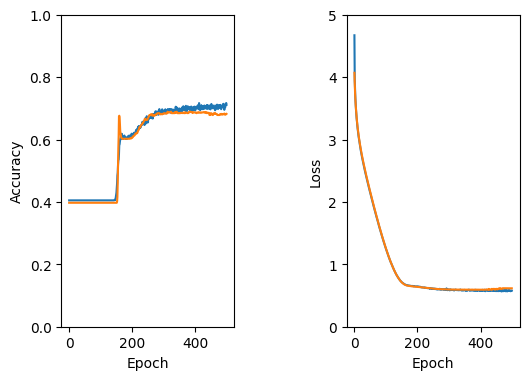

In [304]:
plot_history(classification_history)

2. Clusterization

Model that divides data into clusters, that expected to be close to it's sectors

Probably the best approach is to pack the vector of close values into matrix and clusterize them. 

3. Regression

Model that predicts next close price of a stock given the sequence of previous trades

RNN regression